# Supervised ML Classifiers for Tanzanian Water-Wells Condition

- **Student  :** Daniel Mwaka
- **Student Pace  :** DSF-FT12
- **Phase :** 3
- **Instructor Name  :** Samuel Karu

## 1 Introduction

Access to clean and reliable water is a fundamental human right and a cornerstone of sustainable development. In many developing nations, including Tanzania, ensuring this access remains a significant challenge. While numerous water points have been established, a substantial portion are in disrepair or have ceased to function altogether, leaving millions without consistent access to this vital resource. The ability to proactively identify and address the issues plaguing these water wells is not just an operational necessity but a critical step towards improving public health, economic stability, and overall quality of life for communities. Understanding the factors that contribute to the failure or disrepair of water infrastructure is therefore paramount, enabling targeted interventions and more effective resource allocation.

In this project, I will leverage a dataset focused on Tanzanian Water Wells, part of an active competition on Kaggle, to address this pressing issue. The dataset is available on https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/.
Using this dataset, the project:

- Examines the features related to water well construction, pump type, installation date, and other relevant information to identify key indicators of well condition.
- Builds a robust classifier model to predict the condition of water wells (functional, in need of repair, or non-functional).
- Determines if the selected features exhibit significant predictive patterns regarding water well operational status.
- Recommends an accurate, reliable, and highly generalizable model that can be deployed by NGOs focused on locating wells in need of repair or the Government of Tanzania in making data-supported decisions on frameworks for designing, and constructing new ground water infrustructure projects.

### 1.1 Problem Statement

The Government of Tanzania and Non-Governmental Organizations (NGOs) face a significant challenge in ensuring reliable access to clean water for their population. A substantial number of established water wells are either in disrepair or have completely failed, leading to water scarcity and its associated negative impacts on public health and socio-economic development. There is currently no effective, data-driven method to accurately predict the condition of water wells, making it difficult to prioritize repair efforts, allocate resources efficiently, and inform the design of new, more resilient water infrastructure. This lack of predictive capability results in reactive maintenance, inefficient resource utilization, and continued widespread water scarcity. The Government of Tanzania and NGOs require a solution that can identify water wells that are in need of repair or are likely to fail, enabling proactive interventions and strategic planning for a sustainable water supply.

### 1.2 Objectives

#### 1.2.1 Goal
To recommend an evidence-based supervised ML classification model for predicting the functional condition of water wells in tanzania.

#### 1.2.2 Specific Objectives
1. Preprocess available datasets to justify the predictive power of  features on the target variable.

2. Build, tune, and evaluate the performance of a logistic Regregression model.

3. Build, tune, and evaluate the performance of a Tree-based Classfier.

4. Build, tune, and evaluate the performance of an Ensemble-based Classifier.

5. Compare performance metrics of three classifiers to propose the best alternative for deployment. 


## 2 Exploratory Data Analysis (EDA)
### 2.1 Data Loading and Feature Selection
Load datasets, preliminary feature selection, and data cleaning 

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")

In [2]:
# Load datasets
train_features = pd.read_csv("./data/trainingset.csv")
train_labels = pd.read_csv("./data/trainingsetlabels.csv")

# Merge features and labels for EDA
train_df = pd.merge(train_features, train_labels, on="id")

# Display first five rows
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [4]:
# Drop columns deemed irrelevant to this project
train_df = train_df.drop(columns = ['amount_tsh', 'funder', 'installer', 'latitude', 'longitude', 'scheme_name', 'wpt_name', 'num_private', 'subvillage', 'region_code', 'district_code', 'lga', 'ward', 'public_meeting', 'recorded_by'])

In [5]:
# Drop redundant columns
train_df = train_df.drop(columns =['scheme_management', 'extraction_type', 'extraction_type_group', 'management', 'payment', 'quality_group', 'quantity_group', 'source', 'source_class', 'waterpoint_type'])

In [6]:
# Check for duplicate rows in train_df
duplicates = train_df.duplicated()
print(f"Number of duplicate rows in train_df: {duplicates.sum()}")

# Display duplicate rows
if duplicates.any():
    display(train_df[duplicates])

Number of duplicate rows in train_df: 0


- train_df does not have duplicate entries. 

In [7]:
# Check for missing values
missing = train_df.isnull().sum()
missing_percent = (missing / len(train_df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing, 'Percent': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percent', ascending=False)
missing_df

,Missing Values,Percent
permit,3056,5.144781


- Drop entries with missing values for the `permit` feature to preserve the integrity of train_df. Additionally, dropping entries with nan values for the `permit` column does not a have a significant impact on the size of dataset

In [8]:
# Drop entries with nan values for the `permit` column
train_df = train_df.dropna(subset=['permit'])

In [9]:
# Verify that all selected features dont have missing values
train_df.isna().sum()

id                       0
date_recorded            0
gps_height               0
basin                    0
region                   0
population               0
permit                   0
construction_year        0
extraction_type_class    0
management_group         0
payment_type             0
water_quality            0
quantity                 0
source_type              0
waterpoint_type_group    0
status_group             0
dtype: int64

In [10]:
# Recheck training dataset shape
train_df.shape
print(f"Training dataset consists of: {train_df.shape[0]} rows")
print(f"Training dataset consists of: {train_df.shape[1]} columns")

Training dataset consists of: 56344 rows
Training dataset consists of: 16 columns


### 2.2 Feature Engineering

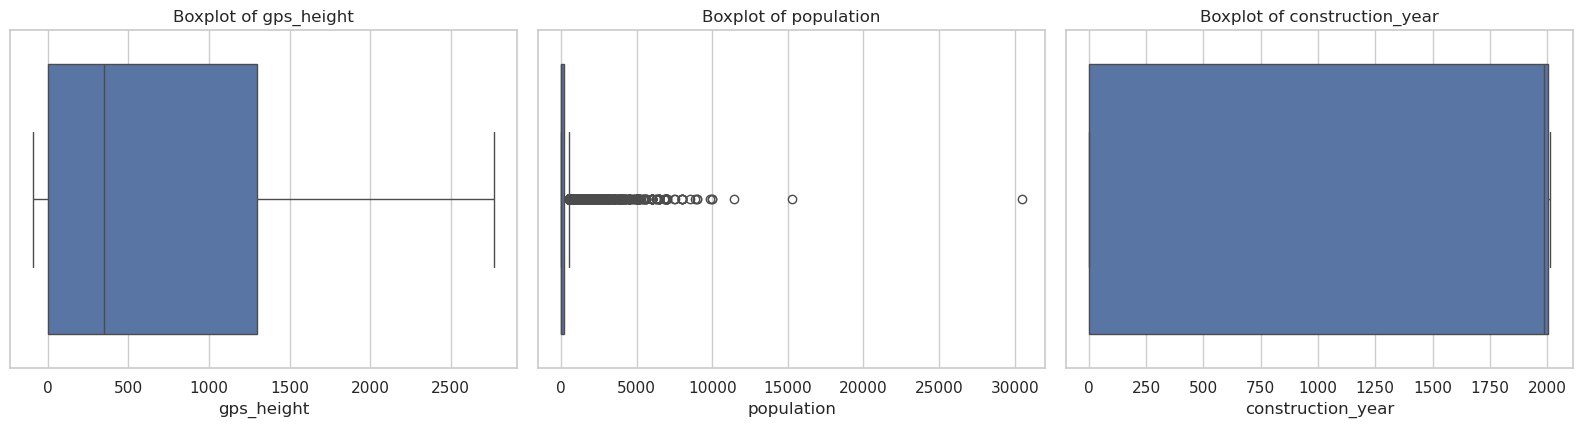

In [11]:
# Define numerical columns (excluding 'id')
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('id')

# Visualize outliers for selected numerical features using boxplots
plt.figure(figsize=(16, 8))
for i, col in enumerate(num_cols[:6]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

#### 2.2.1 Engineer `well_age` Feature

A well's age is an important predictor on it condition. Although the feature is not included in the training.csv dataset; it can be engineered by convering the `date_recorded` variable to datetime and substracting the value from a well's construction year.

In [12]:
# Check unique values for `construction_year` feature
train_df['construction_year'].unique()

array([1999, 2010, 2009, 1986,    0, 2011, 1987, 1991, 1978, 1992, 2008,
       1974, 2000, 2002, 2004, 1972, 2003, 2007, 1973, 1985, 1995, 2006,
       1962, 2005, 1997, 1970, 1996, 1977, 1983, 2012, 1984, 1982, 1976,
       1988, 1989, 1975, 1960, 1990, 1961, 1998, 1963, 1971, 1994, 1968,
       1980, 1993, 2001, 1979, 1967, 1969, 1981, 2013, 1964, 1966, 1965])

In [13]:
# Drop all row entries with a value of 0 in the column `construction_year`
train_df.drop(train_df[train_df['construction_year'] == 0].index, inplace=True)

In [14]:
# Recheck training dataset shape
train_df.shape
print(f"Training dataset consists of: {train_df.shape[0]} rows")
print(f"Training dataset consists of: {train_df.shape[1]} columns")

Training dataset consists of: 36764 rows
Training dataset consists of: 16 columns


In [15]:
# Convert 'date_recorded' to datetime year
train_df['date_recorded'] = pd.to_datetime(train_df['date_recorded']).dt.year

# Calculate well_age = date_recorded - construction_year
train_df['well_age'] = train_df['date_recorded'] - train_df['construction_year']

In [16]:
# Confirm the Engineered feature accurately captures a well's age by the date the data was recorded
train_df[['date_recorded', 'construction_year', 'well_age']].head()

,date_recorded,construction_year,well_age
0,2011,1999,12
1,2013,2010,3
2,2013,2009,4
3,2013,1986,27
5,2011,2009,2


In [17]:
 # Drop 'construction_year' and 'date_recorded' features from train_df
train_df = train_df.drop(columns=['construction_year', 'date_recorded'])

In [18]:
train_df['well_age'].describe()

count    36764.000000
mean        15.245186
std         12.467690
min         -7.000000
25%          4.000000
50%         12.000000
75%         25.000000
max         53.000000
Name: well_age, dtype: float64

- The entries with a negative value for the `well-age` feature are not feasible and are dropped from train_df

In [19]:
# Drop all row entries whose values for 'well_age' are less than zero
train_df = train_df[train_df['well_age'] >= 0]

#### 2.2.2 Multicollinearity Check
- Highly correlated numerical features leads to multicolinearity. Training supervised ML classifiers with highly correlated numerical features increases computational complexity, and elevates the risk for overfitting. 
- Additionally, multicollinearity leads to uncertainity in determining the true contribuction of each feature to predictions.
- Correlation measures are highly sensitive to outliers.

In [20]:
# Identify numerical columns after engineering features
num_cols_1 = train_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols_1.remove('id')

# Remove outliers
for col in num_cols_1:
    lower = train_df[col].quantile(0.01)
    upper = train_df[col].quantile(0.99)
    train_df = train_df[(train_df[col] >= lower) & (train_df[col] <= upper)]


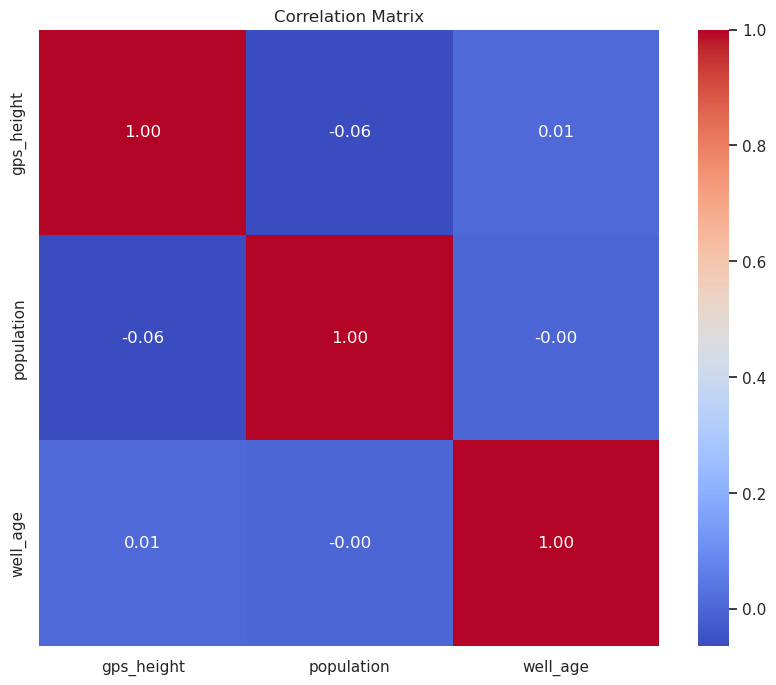

In [21]:
# Plot the correlation matrix
corr = train_df[num_cols_1].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

- There is no multicolineariry among the numerical variables. 
- For inclusion alongside the OneHotEncoded categorical features; these numerical variables must be standardized. 
- The MinMaxScaller is selected because it scales numerical features between 0 and 1. Hence, the scaled numerical features will lie within the same range as the OneHotEncoded dummy variables for categorical features. 

### 2.3 Modularized Preprocessing

After verifying no multicollinearity among numerical features, the modularized preprocessing pipeline is to ensure best practices and avoid data leakage. The steps are as follows:

1. Define exogenous (X) and endogenous (y) variables.
2. Perform train-test split.
3. Apply label encoding to the target variable.
4. Address class imbalance using undersampling.
5. Scale numerical features using MinMaxScaler.
6. One-hot encode categorical features.
7. Concatenate processed features into final DataFrames for modeling.


In [22]:
# Define exogenous (X) and endogenous (y) variables
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('id')
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('status_group')

X = train_df[num_cols + cat_cols]
y = train_df['status_group']

# Train-test split (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print("----------------------------------------------------")
print(f"y_train distribution:\n{y_train.value_counts()}")

X_train shape: (28261, 13)
X_test shape: (7066, 13)
----------------------------------------------------
y_train distribution:
status_group
functional                 15918
non functional             10489
functional needs repair     1854
Name: count, dtype: int64


Before building supervised machine learning models; the class distribuction of the target variable for the training set must be balanced to optimize the performance of the model to minimize biase towards the majority class. Training ML classifiers on an unbalanced data can result to a model that performs exceptionally well in making predictions for the majority class but poorly for the minority classes. Additionally, it compromises the legibility of standard evaluation measures when comparing the performance of different models to determine the best fit/ most appropriate alternative respective to a specific business problem. For instance, the accuracy metrics can be deceptive since a model's score is skewed upwards if it is able to make accurate predictions for the majority class even if it performs poorly in predicting the minority class. 

In [23]:
# Label encode the target variable
y_train = y_train.copy()
y_test = y_test.copy()
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print(f"Encoded y_train distribution: {np.bincount(y_train_enc)}")
print(f"Encoded y_test distribution: {np.bincount(y_test_enc)}")

Encoded y_train distribution: [15918  1854 10489]
Encoded y_test distribution: [3980  464 2622]


The classes for the target variable (`status_group`) are unbalanced in both the training (`y_train`) and test (`y_test`) sets. Specifically, the majority class ("functional") contains significantly more samples than the minority classes (s"functional needs repair" and "non functional"). This imbalance can bias machine learning models toward predicting the majority class, resulting in poor performance on the minority classes. To address this, undersampling of the majority classes is adopted. The technique involves randomly reducing the number of samples in the majority classes to match the number of samples in the minority class. The rationale for using undersampling is as follows:

- **Improved Model Generalization:** By balancing the class distribution, the model is encouraged to learn patterns for all classes, not just the majority, leading to better generalization and fairer predictions.
- **Reliable Evaluation Metrics:** Balanced classes ensure that evaluation metrics (such as accuracy, precision, recall, and F1-score) more accurately reflect the model's performance across all classes, rather than being dominated by the majority class.
- **Simplicity and Data Integrity:** Given that the minority class is not extremely small, undersampling avoids the risk of overfitting associated with oversampling techniques (like SMOTE) and maintains the authenticity of the data.

In [24]:
# Address class imbalance using undersampling
from sklearn.utils import resample

# Combine X_train and y_train_enc for resampling
Xy_train = X_train.copy()
Xy_train['target'] = y_train_enc

# Find the minority class count
min_class_count = np.bincount(y_train_enc).min()

# Separate each class
class_0 = Xy_train[Xy_train['target'] == 0]
class_1 = Xy_train[Xy_train['target'] == 1]
class_2 = Xy_train[Xy_train['target'] == 2]

class_0_down = resample(class_0, replace=False, n_samples=min_class_count, random_state=42)
class_2_down = resample(class_2, replace=False, n_samples=min_class_count, random_state=42)

# Combine undersampled classes
Xy_balanced = pd.concat([class_0_down, class_1, class_2_down])
Xy_balanced = Xy_balanced.sample(frac=1, random_state=42)

X_train_bal = Xy_balanced.drop('target', axis=1)
y_train_bal = Xy_balanced['target']

print("Class distribution after undersampling:")
print(y_train_bal.value_counts())

Class distribution after undersampling:
target
0    1854
1    1854
2    1854
Name: count, dtype: int64


In [25]:
# Scale numerical features using MinMaxScaler
scaler = MinMaxScaler()

# Fit on X_train_bal, transform both X_train_bal and X_test
X_train_num = scaler.fit_transform(X_train_bal[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

# Convert back to DataFrame for easy concatenation
X_train_num_df = pd.DataFrame(X_train_num, columns=num_cols, index=X_train_bal.index)
X_test_num_df = pd.DataFrame(X_test_num, columns=num_cols, index=X_test.index)

In [26]:
# One-hot encode categorical features
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Fit on X_train_bal, transform both X_train_bal and X_test
X_train_cat = ohe.fit_transform(X_train_bal[cat_cols])
X_test_cat = ohe.transform(X_test[cat_cols])

cat_feature_names = ohe.get_feature_names_out(cat_cols)
X_train_cat_df = pd.DataFrame(X_train_cat, columns=cat_feature_names, index=X_train_bal.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=cat_feature_names, index=X_test.index)

In [27]:
# Concatenate processed features into final DataFrames
X_train_final = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
X_test_final = pd.concat([X_test_num_df, X_test_cat_df], axis=1)

print(f"Final X_train shape: {X_train_final.shape}")
print(f"Final X_test shape: {X_test_final.shape}")
X_train_final.head()

Final X_train shape: (5562, 65)
Final X_test shape: (7066, 65)


,gps_height,population,well_age,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,...,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_group_communal standpipe,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
19,0.811621,0.000417,0.431818,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
55140,0.577848,0.541667,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25522,0.536087,0.024167,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
25081,0.618248,0.125000,0.340909,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4525,0.251929,0.062500,0.681818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [28]:
# Export preprocessed data for Tableau
export_df = X_train_final.copy()
export_df['status_group'] = le.inverse_transform(y_train_bal)
export_df.to_csv('./data/water-wells-data.csv', index=False)
print("Preprocessed data exported to 'water-wells-data.csv'.")

Preprocessed data exported to 'water-wells-data.csv'.


## 3 Modelling 

### 3.1 Logistic Regression Model

Build a simple supervised classification model (Logistic Regression), evaluate its performance, and discuss its limitations. The simple model is tuned to re-evaluate performance before proceeding on to build alternative classification models.

#### 3.1.1 Untuned Logistic Regression Model

In [29]:
# Fit Logistic Regression Model on Preprocessed and Balanced Data
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_final, y_train_bal)

LogisticRegression(max_iter=1000, random_state=42)

In [30]:
# Predict on Train and Test Sets (using preprocessed data)
y_pred_train = logreg.predict(X_train_final)
y_proba_train = logreg.predict_proba(X_train_final)
y_pred_test = logreg.predict(X_test_final)
y_proba_test = logreg.predict_proba(X_test_final)

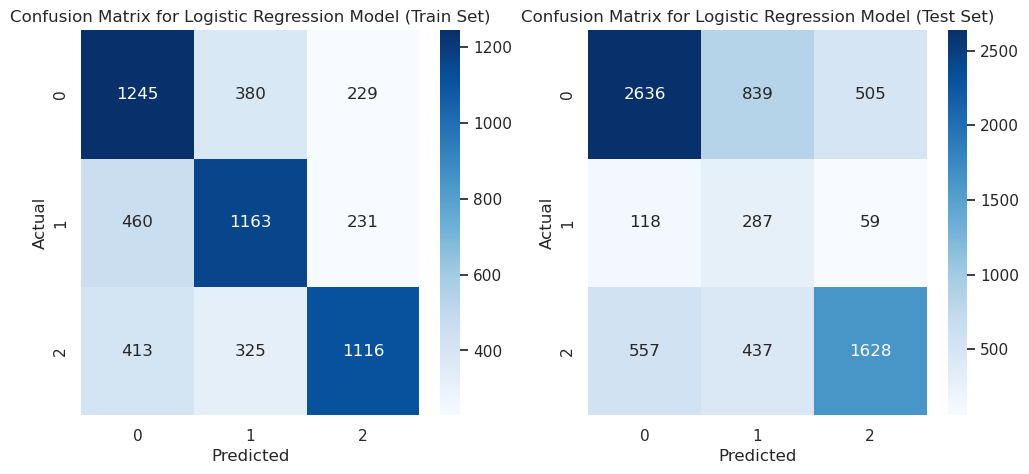

In [31]:
# Plot confusion matrices for logistic regression model on both train and test sets
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm_train = confusion_matrix(y_train_bal, y_pred_train)
cm_test = confusion_matrix(y_test_enc, y_pred_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix for Logistic Regression Model (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix for Logistic Regression Model (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig("./images/confusion-matrices-untuned-logistic-regression-model.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

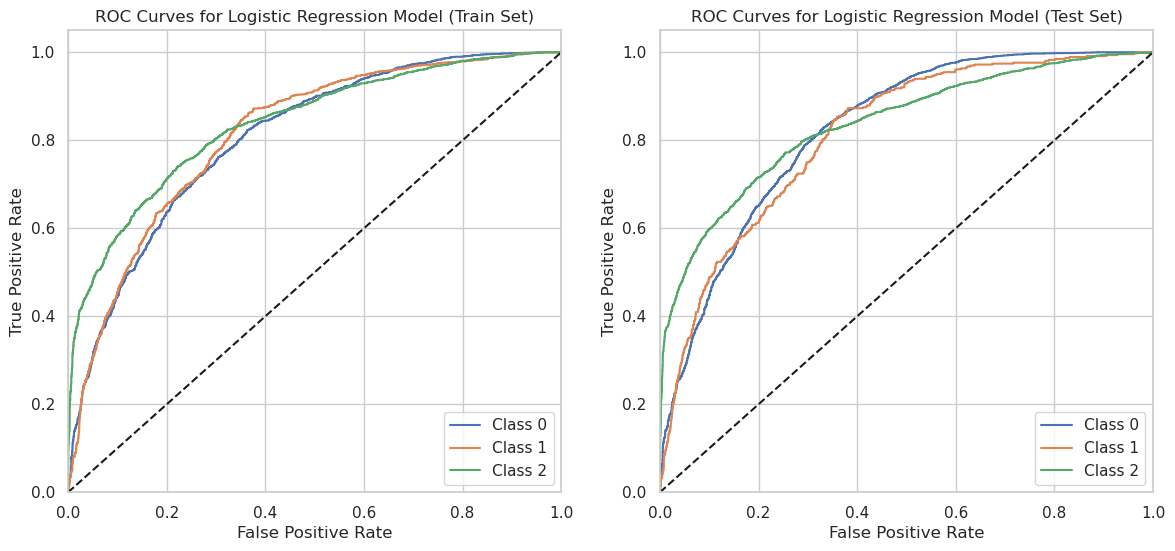

In [32]:
# Plot ROC curves for logistic regression model on both train and test sets 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
import numpy as np

n_classes = len(np.unique(y_train_bal))
y_train_bin = label_binarize(y_train_bal, classes=range(n_classes))
y_test_bin = label_binarize(y_test_enc, classes=range(n_classes))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves for Logistic Regression Model (Train Set)')
axes[0].legend(loc='lower right')
axes[0].grid(True)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_test[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves for Logistic Regression Model (Test Set)')
axes[1].legend(loc='lower right')
axes[1].grid(True)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])

plt.savefig("./images/roc-curves-untuned-logistic-regression-model.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

#### 3.1.2 Tuned Logistic Regression Model

In [33]:
# Hyperparameter tuning for Logistic Regression (Tuned Model)
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
gs.fit(X_train_final, y_train_bal)
print(f"Best parameters: {gs.best_params_}")

Best parameters: {'C': 100}


In [34]:
# Predict on train and test sets (using preprocessed data)
y_pred_gs_train = gs.predict(X_train_final)
y_proba_gs_train = gs.predict_proba(X_train_final)
y_pred_gs = gs.predict(X_test_final)
y_proba_gs = gs.predict_proba(X_test_final)

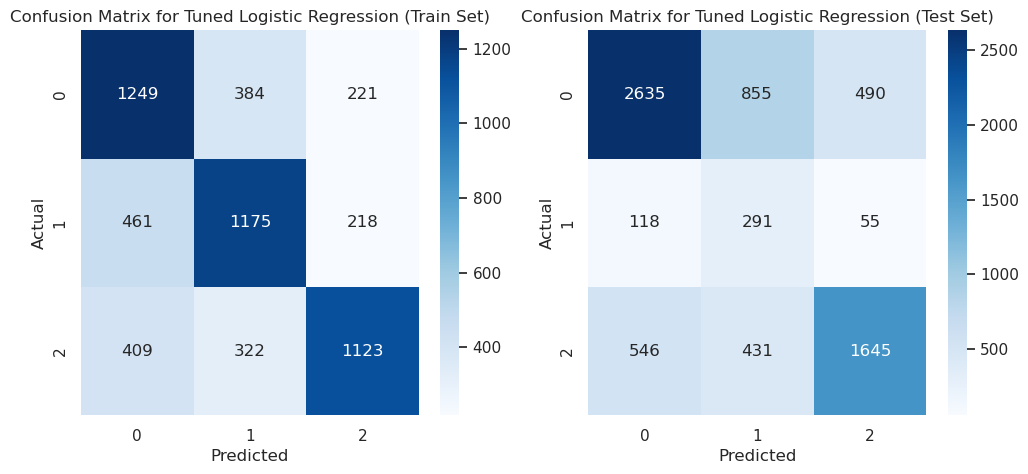

In [35]:
# Plot confusion matrices for logistic regression model on both train and test sets 
cm_train = confusion_matrix(y_train_bal, y_pred_gs_train)
cm_test = confusion_matrix(y_test_enc, y_pred_gs)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix for Tuned Logistic Regression (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix for Tuned Logistic Regression (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig("./images/confusion-matrices-tuned-logistic-regression-model.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

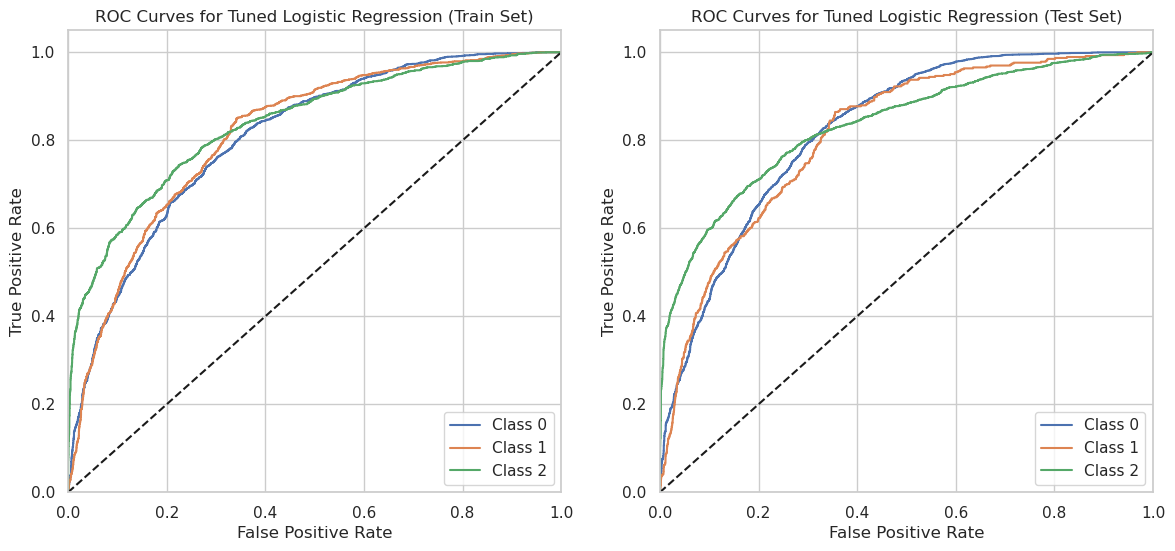

In [36]:
# Plot ROC curves for tuned logistic regression model on both train and test sets 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
import numpy as np

n_classes = len(np.unique(y_train_bal))
y_train_bin = label_binarize(y_train_bal, classes=range(n_classes))
y_test_bin = label_binarize(y_test_enc, classes=range(n_classes))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_gs_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves for Tuned Logistic Regression (Train Set)')
axes[0].legend(loc='lower right')
axes[0].grid(True)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_gs[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves for Tuned Logistic Regression (Test Set)')
axes[1].legend(loc='lower right')
axes[1].grid(True)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])

plt.savefig("./images/roc-curves-tuned-logistic-regression-model.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [37]:
# Evaluate performance on train and test set for untuned logistic regression model
acc_train = accuracy_score(y_train_bal, y_pred_train)
prec_train = precision_score(y_train_bal, y_pred_train, average='weighted')
rec_train = recall_score(y_train_bal, y_pred_train, average='weighted')
f1_train = f1_score(y_train_bal, y_pred_train, average='weighted')
roc_auc_train = roc_auc_score(y_train_bal, y_proba_train, multi_class='ovr')

acc_test = accuracy_score(y_test_enc, y_pred_test)
prec_test = precision_score(y_test_enc, y_pred_test, average='weighted')
rec_test = recall_score(y_test_enc, y_pred_test, average='weighted')
f1_test = f1_score(y_test_enc, y_pred_test, average='weighted')
roc_auc_test = roc_auc_score(y_test_enc, y_proba_test, multi_class='ovr')

# Evaluate performance on train and test set for tuned logistic regression model
gs_train_preds = y_pred_gs_train
gs_train_proba = y_proba_gs_train
gs_test_preds = y_pred_gs
gs_test_proba = y_proba_gs

acc_gs_train = accuracy_score(y_train_bal, gs_train_preds)
prec_gs_train = precision_score(y_train_bal, gs_train_preds, average='weighted')
rec_gs_train = recall_score(y_train_bal, gs_train_preds, average='weighted')
f1_gs_train = f1_score(y_train_bal, gs_train_preds, average='weighted')
roc_auc_gs_train = roc_auc_score(y_train_bal, gs_train_proba, multi_class='ovr')

acc_gs = accuracy_score(y_test_enc, gs_test_preds)
prec_gs = precision_score(y_test_enc, gs_test_preds, average='weighted')
rec_gs = recall_score(y_test_enc, gs_test_preds, average='weighted')
f1_gs = f1_score(y_test_enc, gs_test_preds, average='weighted')
roc_auc_gs = roc_auc_score(y_test_enc, gs_test_proba, multi_class='ovr')

# Create a DataFrame with metrics for both untuned and tuned Logistic Regression
metrics_df = pd.DataFrame({
    'Model': ['Untuned Model', 'Tuned Model'],
    'Train Accuracy': [acc_train, acc_gs_train],
    'Test Accuracy': [acc_test, acc_gs],
    'Train Precision': [prec_train, prec_gs_train],
    'Test Precision': [prec_test, prec_gs],
    'Train Recall': [rec_train, rec_gs_train],
    'Test Recall': [rec_test, rec_gs],
    'Train F1-score': [f1_train, f1_gs_train],
    'Test F1-score': [f1_test, f1_gs],
    'Train ROC-AUC': [roc_auc_train, roc_auc_gs_train],
    'Test ROC-AUC': [roc_auc_test, roc_auc_gs]
})

metrics_df.set_index('Model', inplace=True)
metrics_df

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-score,Test F1-score,Train ROC-AUC,Test ROC-AUC
Model,,,,,,,,,,
Untuned Model,0.633585,0.644070,0.639511,0.736085,0.633585,0.644070,0.634183,0.676859,0.818500,0.825001
Tuned Model,0.637720,0.646901,0.644349,0.740737,0.637720,0.646901,0.638474,0.680231,0.819004,0.825108


#### 3.1.3 Model Performance Comparison: Untuned vs. Tuned Logistic Regression

- The untuned Logistic Regression model achieved an F1-score of approximately 0.63 on (train) and 0.68 on (test), with an accuracy of about 63% on both sets. The ROC-AUC score is about 82% on (train) and (test).
- After hyperparameter tuning, the tuned Logistic Regression model showed a slight improvement, with the F1-score increasing to about 0.64 (train) and 0.68 (test). The accuracy improved slightly to 64% (train) and to 65% on test set. The ROC-AUC score improved to around 82% on (train) and (test), indicating the tuned model's better overall discrimination between classes.
- Although the tuned model shows an improvement in the f1-score and accuracy; the Logistic Regression may have reached its prediction capacity for this dataset. Additionally, the confusion matrices substantiate the Logistic Regression model's limitations. 

**Limitation:** Logistic Regression is limited in capturing interactions between features when fitting complex datasets since its approach framework tries to separate classes using hyperplanes. To address these limitations, it is necessary to build a Decision Tree Classifier model. Tree-based classifiers can model non-linear relationships and feature interactions more effectively, potentially improving classification performance, especially for classes that are harder to separate leveraging hyperplanes. The next section models a Decision Tree Classifier. 

### 3.2 Tree-Based Classification Model

A Decision Tree Classifier is a supervised machine learning algorithm used for classification tasks. It works by recursively splitting the dataset into subsets based on the value of input features, forming a tree-like structure of decisions. Each internal node represents a decision based on a feature, each branch represents the outcome of that decision, and each leaf node represents a class label (prediction).

Decision Trees can capture non-linear relationships and interactions between features without requiring explicit feature engineering. They can model complex decision boundaries by splitting the data multiple times based on different features and thresholds. This flexibility allows Decision Trees to potentially achieve better predictive performance than Logistic Regression, especially when the underlying patterns in the data are not well-approximated by linear models. Hence, Decision Tree Classifiers have substantial potential to outperform the Logistic Regression model in a ternary classification problem.

#### 3.2.1 Untuned Decision Tree Classifier

In [38]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree
dt = DecisionTreeClassifier(random_state=42, criterion='gini')
dt.fit(X_train_final, y_train_bal)

DecisionTreeClassifier(random_state=42)

In [39]:
# Predict for train and test set
y_pred_dt_train = dt.predict(X_train_final)
y_proba_dt_train = dt.predict_proba(X_train_final)
y_pred_dt_test = dt.predict(X_test_final)
y_proba_dt_test = dt.predict_proba(X_test_final)

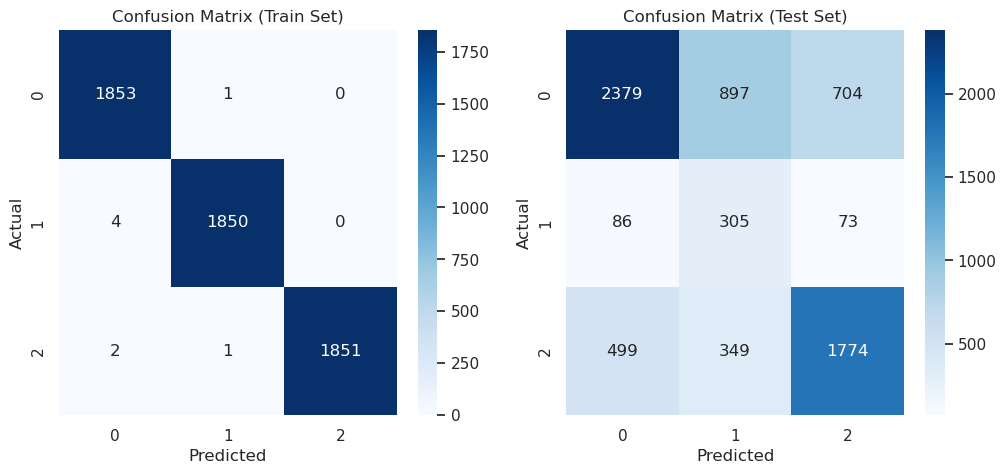

In [40]:
# Confusion matrices for Decision Tree Classifier in prediciting for both train and test sets
cm_train = confusion_matrix(y_train_bal, y_pred_dt_train)
cm_test = confusion_matrix(y_test_enc, y_pred_dt_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig("./images/confusion_matrices-untuned-decision-tree-classifier.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

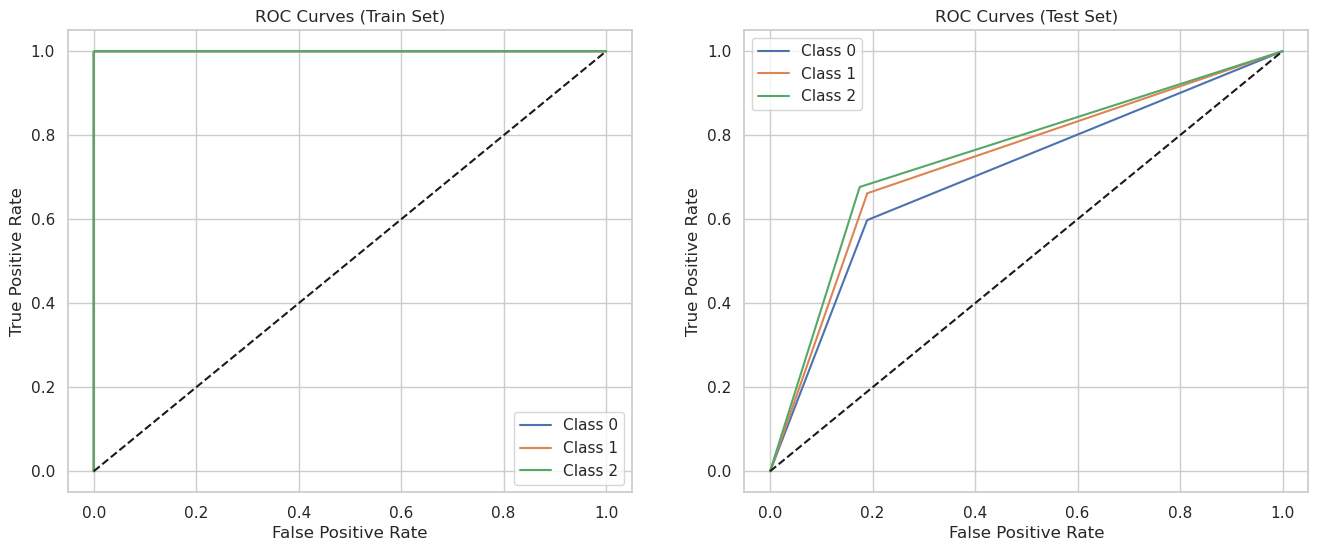

In [41]:
# ROC Curves for Untuned Decision Tree Classifier in predicitng both train and test sets
from sklearn.preprocessing import label_binarize
n_classes = len(np.unique(y))
y_train_bin = label_binarize(y_train_bal, classes=range(n_classes))
y_test_bin = label_binarize(y_test_enc, classes=range(n_classes))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves for untuned Decision Tree Classifier on Train Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_dt_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0,1],[0,1],'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves (Train Set)')
axes[0].legend()

# ROC Curves for Untuned Decision Tree Classifier on Test Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_dt_test[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0,1],[0,1],'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves (Test Set)')
axes[1].legend()

plt.savefig("./images/roc-curves-untuned-decision-tree-classifier.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

#### 3.2.2 Tuned Decision Tree Classifier

In [42]:
# Hyperparameter tuning for Decision Tree Classifier
param_grid_dt = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gs_dt = GridSearchCV(DecisionTreeClassifier(random_state=42, criterion='gini'), param_grid_dt, cv=5, scoring='f1_weighted', n_jobs=-1)
gs_dt.fit(X_train_final, y_train_bal)
print(f"Best Decision Tree params: {gs_dt.best_params_}")

Best Decision Tree params: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [43]:
# Predict on train and test sets
y_pred_dt_gs_train = gs_dt.predict(X_train_final)
y_proba_dt_gs_train = gs_dt.predict_proba(X_train_final)
y_pred_dt_gs = gs_dt.predict(X_test_final)
y_proba_dt_gs = gs_dt.predict_proba(X_test_final)

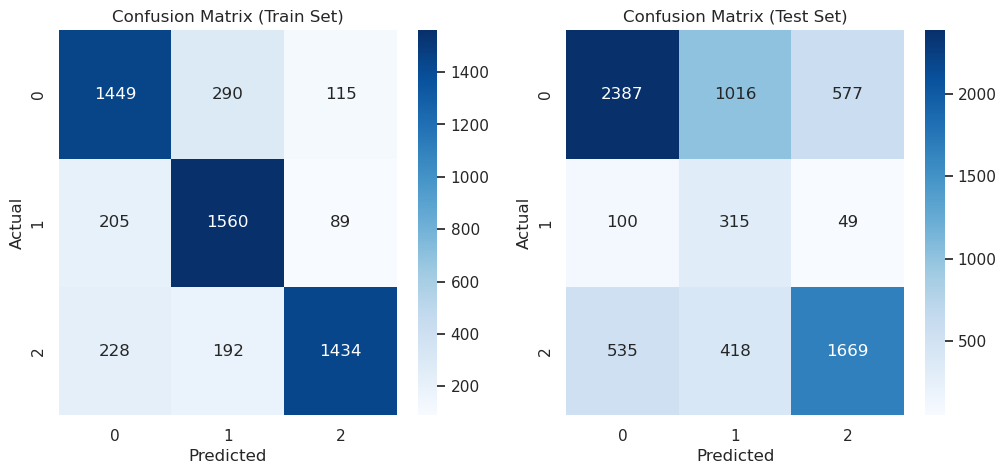

In [44]:
# Confusion matrices for Tuned Decision Tree Classifier in prediciting for both train and test sets
cm_train = confusion_matrix(y_train_bal, y_pred_dt_gs_train)
cm_test = confusion_matrix(y_test_enc, y_pred_dt_gs)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig("./images/confusion_matrices-tuned-decision-tree-classifier.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

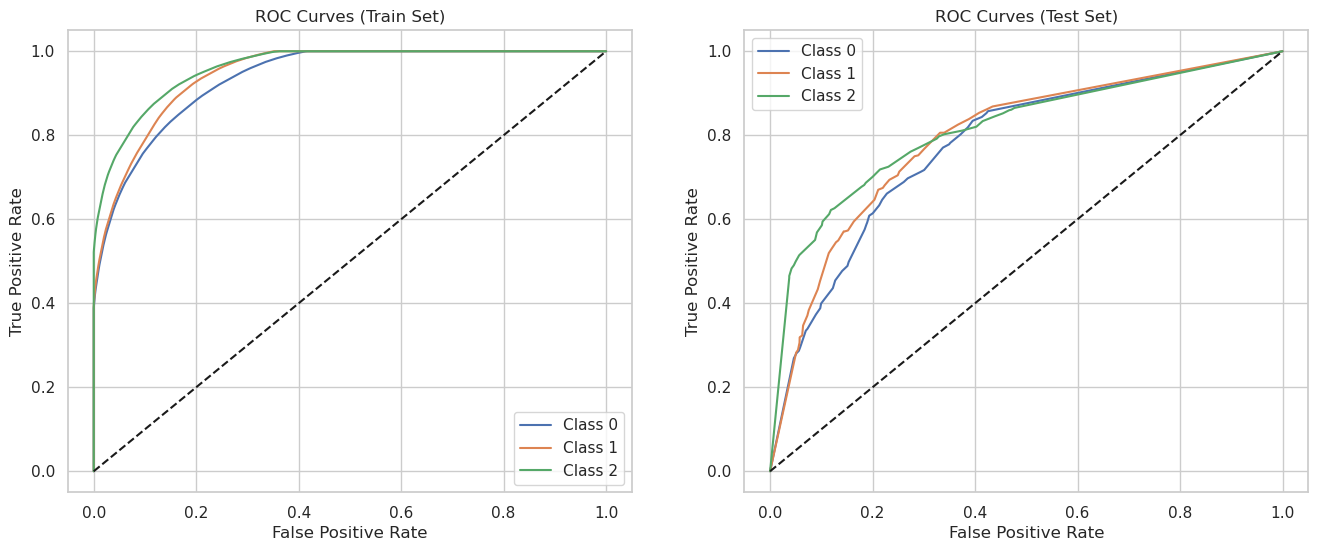

In [45]:
# ROC Curves for Tuned Decision Tree Classifier in predicitng both train and test sets
from sklearn.preprocessing import label_binarize
n_classes = len(np.unique(y))
y_train_bin = label_binarize(y_train_bal, classes=range(n_classes))
y_test_bin = label_binarize(y_test_enc, classes=range(n_classes))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves for untuned Decision Tree Classifier on Train Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_dt_gs_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0,1],[0,1],'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves (Train Set)')
axes[0].legend()

# ROC Curves for Untuned Decision Tree Classifier on Test Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_dt_gs[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0,1],[0,1],'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves (Test Set)')
axes[1].legend()

plt.savefig("./images/roc-curves-tuned-decision-tree-classifier.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [46]:
# Compute metrics for Untuned Decision Tree Classifier
acc_dt_train = accuracy_score(y_train_bal, y_pred_dt_train)
prec_dt_train = precision_score(y_train_bal, y_pred_dt_train, average='weighted')
rec_dt_train = recall_score(y_train_bal, y_pred_dt_train, average='weighted')
f1_dt_train = f1_score(y_train_bal, y_pred_dt_train, average='weighted')
roc_auc_dt_train = roc_auc_score(y_train_bal, y_proba_dt_train, multi_class='ovr')

acc_dt_test = accuracy_score(y_test_enc, y_pred_dt_test)
prec_dt_test = precision_score(y_test_enc, y_pred_dt_test, average='weighted')
rec_dt_test = recall_score(y_test_enc, y_pred_dt_test, average='weighted')
f1_dt_test = f1_score(y_test_enc, y_pred_dt_test, average='weighted')
roc_auc_dt_test = roc_auc_score(y_test_enc, y_proba_dt_test, multi_class='ovr')

# Compute metrics for Tuned Decision Tree Classifier
acc_dt_gs_train = accuracy_score(y_train_bal, y_pred_dt_gs_train)
prec_dt_gs_train = precision_score(y_train_bal, y_pred_dt_gs_train, average='weighted')
rec_dt_gs_train = recall_score(y_train_bal, y_pred_dt_gs_train, average='weighted')
f1_dt_gs_train = f1_score(y_train_bal, y_pred_dt_gs_train, average='weighted')
roc_auc_dt_gs_train = roc_auc_score(y_train_bal, y_proba_dt_gs_train, multi_class='ovr')

acc_dt_gs_test = accuracy_score(y_test_enc, y_pred_dt_gs)
prec_dt_gs_test = precision_score(y_test_enc, y_pred_dt_gs, average='weighted')
rec_dt_gs_test = recall_score(y_test_enc, y_pred_dt_gs, average='weighted')
f1_dt_gs_test = f1_score(y_test_enc, y_pred_dt_gs, average='weighted')
roc_auc_dt_gs_test = roc_auc_score(y_test_enc, y_proba_dt_gs, multi_class='ovr')

# Create DataFrame with metrics
dt_metrics_df = pd.DataFrame({
    'Model': ['Untuned Model', 'Tuned Model'],
    'Train Accuracy': [acc_dt_train, acc_dt_gs_train],
    'Test Accuracy': [acc_dt_test, acc_dt_gs_test],
    'Train Precision': [prec_dt_train, prec_dt_gs_train],
    'Test Precision': [prec_dt_test, prec_dt_gs_test],
    'Train Recall': [rec_dt_train, rec_dt_gs_train],
    'Test Recall': [rec_dt_test, rec_dt_gs_test],
    'Train F1-score': [f1_dt_train, f1_dt_gs_train],
    'Test F1-score': [f1_dt_test, f1_dt_gs_test],
    'Train ROC-AUC': [roc_auc_dt_train, roc_auc_dt_gs_train],
    'Test ROC-AUC': [roc_auc_dt_test, roc_auc_dt_gs_test]
})

# Set the index to 'Model'
dt_metrics_df.set_index('Model', inplace=True)

dt_metrics_df

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-score,Test F1-score,Train ROC-AUC,Test ROC-AUC
Model,,,,,,,,,,
Untuned Model,0.998562,0.630909,0.998564,0.723053,0.998562,0.630909,0.998562,0.660330,0.999998,0.730429
Tuned Model,0.798813,0.618596,0.803113,0.726588,0.798813,0.618596,0.799274,0.654638,0.948504,0.793782


#### 3.2.3 Model Performance Interpretation: Untuned vs. Tuned Decision Tree

- The untuned Decision Tree classifier achieved an F1-score of 100% on the training set and 66% on the test set, with accuracy around 100% (train) and 63% (test). The ROC-AUC score (train) is around 100% and 73% (test).
- After hyperparameter tuning, the Decision Tree's F1-score (train) dropped to 80% and on test decreased to 65%. The accuracy droped to 80% (train) and dipped to 62% (test. The ROC-AUC score (train) dropped to 95% on (train) but improved to 79% on the test set.  
- Across all the metrics; the untuned and the tuned Decision Tree classifiers show a substantial gap between training and test performance metrics. This disparity alludes to potential overfitting.
- The confusion matrices indicate that certain classes are still misclassified at a notable rate, and the model may struggle with minority classes.

**Limitations:** Decision Trees can easily overfit the training data, especially with many features or when the tree is deep, leading to poor generalization. Small changes in the data can result in very different tree structures, making the model less robust. Additionally, a single tree may not capture complex, non-linear relationships as effectively as ensemble methods. Thus, building a Gradient Boosting Classifier is necessary to achieve higher accuracy, better generalization, and improved performance on all classes in this ternary classification problem. It addresses the limitations of single decision trees and is widely regarded as a state-of-the-art approach for structured tabular data.

### 3.3 Ensemble-Based Classification Model

A Gradient Boosting Classifiers fits a number of randomized decision trees on various sub-samples of the training dataset and uses averaging to improve the predictive accuracy and control over-fitting. A Gradient Boosting Classifier is an ensemble method since the modelled decision trees are build sequentially. Each new tree in the sequence is trained to correct the errors made by the sum of previously built trees. Such an iterative error-correction process gradually improves the model's overall performance, reduces bias and minimizes variance across the model's predictions. Thus, building a Gradient Boosting Classifier is necessary since ensemble models:
- Reduce overfitting by combining multiple trees and using regularization.
- Improve predictive accuracy, especially for complex, non-linear relationships.
- Handle class imbalance and minority class prediction better through boosting.
- Are more robust and stable than a single decision tree.


#### 3.3.1 Untuned Gradient Boosting Classifier

In [47]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting on balanced data
gb_bal = GradientBoostingClassifier(random_state=42)
gb_bal.fit(X_train_final, y_train_bal)

GradientBoostingClassifier(random_state=42)

In [48]:
# Predict on train and test sets
y_pred_gb_train = gb_bal.predict(X_train_final)
y_proba_gb_train = gb_bal.predict_proba(X_train_final)
y_pred_gb_test = gb_bal.predict(X_test_final)
y_proba_gb_test = gb_bal.predict_proba(X_test_final)

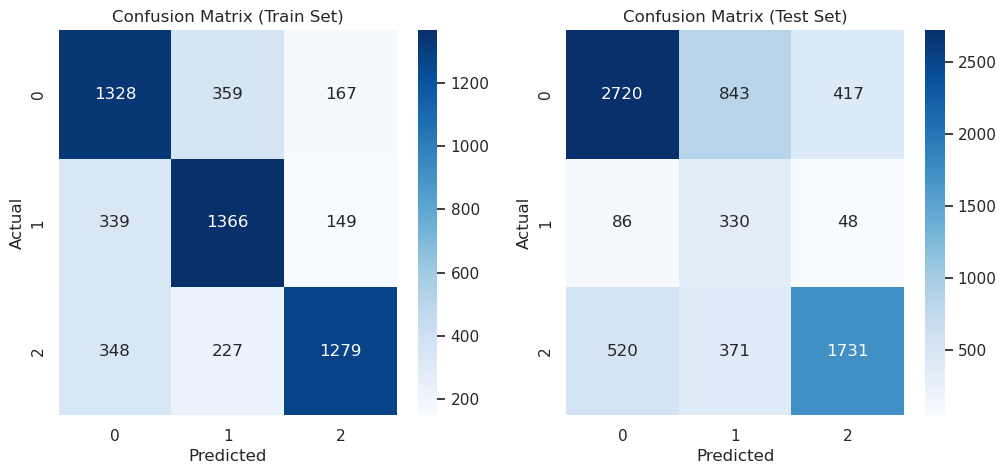

In [49]:
# Plot confusion matrices for Gradient Boosting Classifier on both train and test sets
cm_gb_train = confusion_matrix(y_train_bal, y_pred_gb_train)
cm_gb_test = confusion_matrix(y_test_enc, y_pred_gb_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train set confusion matrix
sns.heatmap(cm_gb_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Test set confusion matrix
sns.heatmap(cm_gb_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig("./images/confusion-matrices-untuned-gradient-boosting-classifier.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

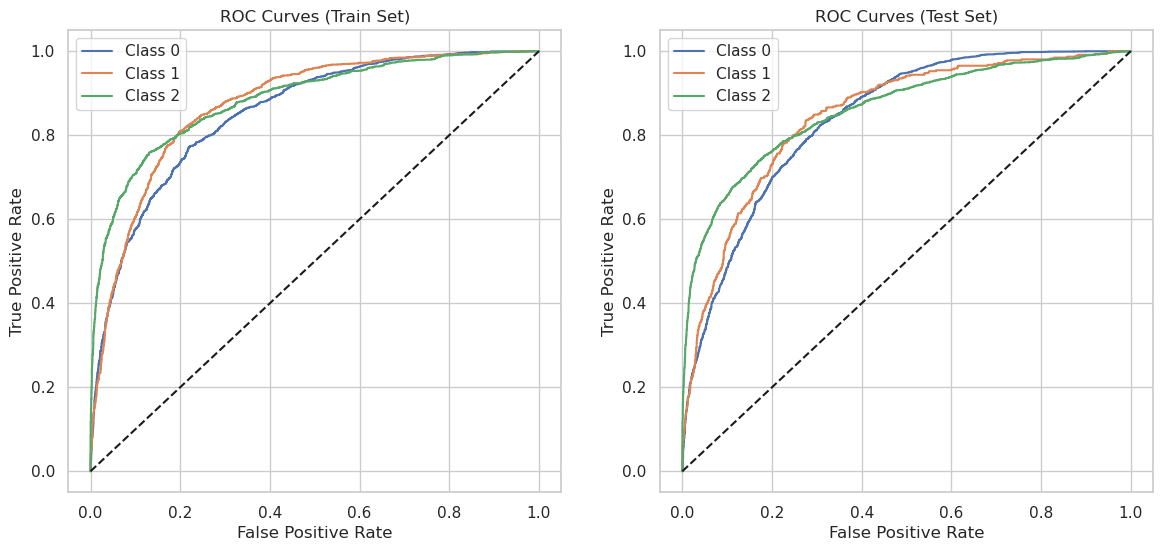

In [50]:
from sklearn.preprocessing import label_binarize

# Plot ROC curves for Gradient Boosting Classifier on both train and test sets

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Binarize the true labels for multiclass ROC
y_train_bin = label_binarize(y_train_bal, classes=range(n_classes))
y_test_bin = label_binarize(y_test_enc, classes=range(n_classes))

# ROC curves for train set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_gb_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves (Train Set)')
axes[0].legend()
axes[0].grid(True)

# ROC curves for test set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_gb_test[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves (Test Set)')
axes[1].legend()
axes[1].grid(True)

plt.savefig("./images/roc-curves-untuned-gradient-boosting-classifier.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [51]:
# Define parameter grid for tuning the Gradient Boosting Classifier
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2', None],
}


# # Define a broader search space
# param_grid_gb = {
#     'n_estimators': [100, 200, 300, 500], 
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'max_depth': [3, 4, 5, 6],
#     'subsample': [0.7, 0.8, 0.9, 1.0],
#     'max_features': ['sqrt', 'log2', None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     # 'validation_fraction': [0.1], 
#     # 'n_iter_no_change': [20],      
# }

# Initialize GridSearchCV
gs_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

# Fit on balanced training data
gs_gb.fit(X_train_final, y_train_bal)
print(f"Best Gradient Boosting params: {gs_gb.best_params_}")

Best Gradient Boosting params: {'learning_rate': 0.1, 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200, 'subsample': 0.8}


In [52]:
# Predict on train and test sets
y_pred_gb_rs_train = gs_gb.predict(X_train_final)
y_proba_gb_rs_train = gs_gb.predict_proba(X_train_final)
y_pred_gb_rs = gs_gb.predict(X_test_final)
y_proba_gb_rs = gs_gb.predict_proba(X_test_final)

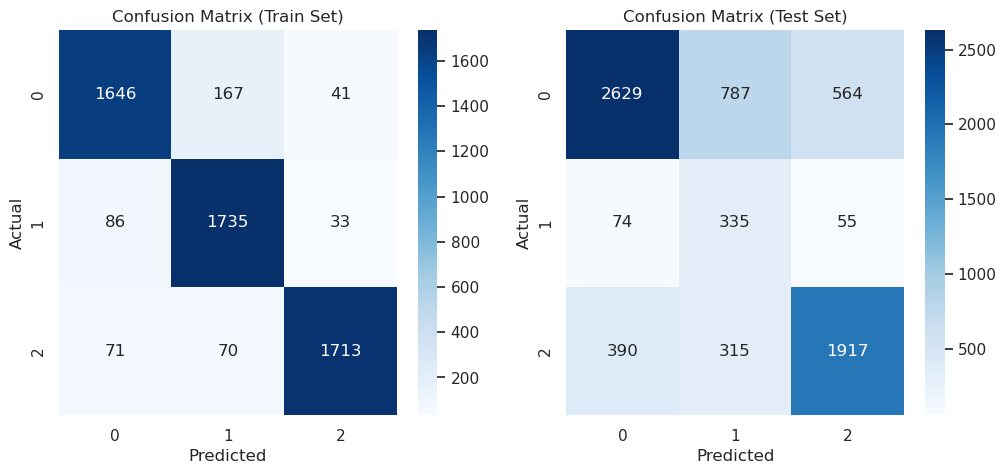

In [53]:
# Confusion matrices for Tuned Gradient Boosting Classifier in predicting for both train and test sets
cm_train_gb_rs = confusion_matrix(y_train_bal, y_pred_gb_rs_train)
cm_test_gb_rs = confusion_matrix(y_test_enc, y_pred_gb_rs)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Train Set
sns.heatmap(cm_train_gb_rs, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot for Test Set
sns.heatmap(cm_test_gb_rs, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig("./images/confusion-matrices-tuned-gradient-boosting-classifier.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

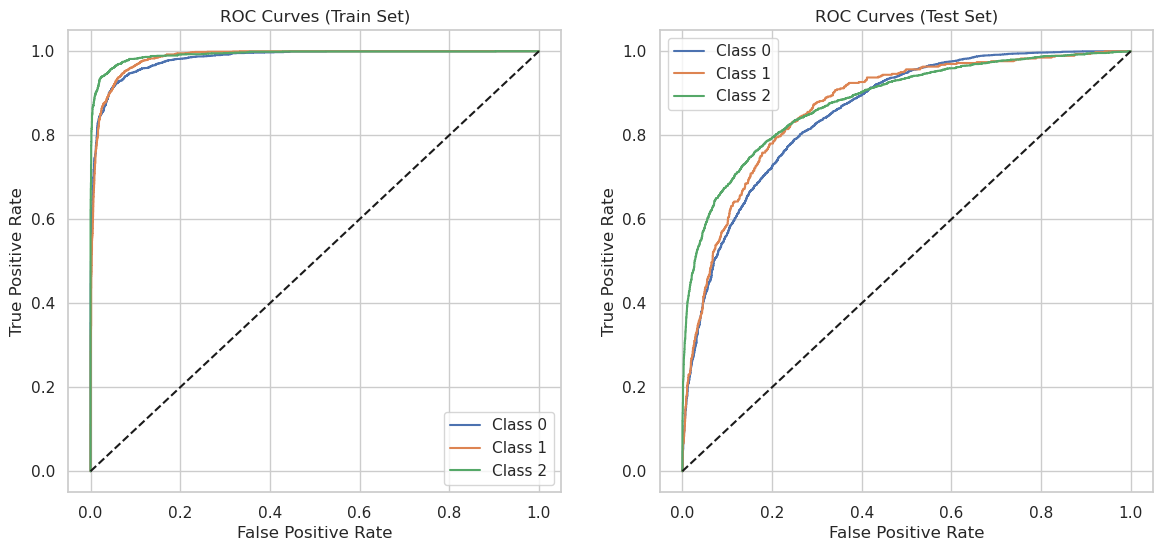

In [54]:
# Plot ROC curves for the tuned Gradient Boosting model on both train and test sets
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC curves for train set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_gb_rs_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves (Train Set)')
axes[0].legend()
axes[0].grid(True)

# ROC curves for test set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_gb_rs[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves (Test Set)')
axes[1].legend()
axes[1].grid(True)

plt.savefig("./images/roc-curves-tuned-gradient-boosting-classifier.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [55]:
# Compute performance metrics for untuned Gradient Boosting Classifier
acc_gb_train = accuracy_score(y_train_bal, y_pred_gb_train)
prec_gb_train = precision_score(y_train_bal, y_pred_gb_train, average='weighted')
rec_gb_train = recall_score(y_train_bal, y_pred_gb_train, average='weighted')
f1_gb_train = f1_score(y_train_bal, y_pred_gb_train, average='weighted')
roc_auc_gb_train = roc_auc_score(y_train_bal, y_proba_gb_train, multi_class='ovr')

acc_gb_test = accuracy_score(y_test_enc, y_pred_gb_test)
prec_gb_test = precision_score(y_test_enc, y_pred_gb_test, average='weighted')
rec_gb_test = recall_score(y_test_enc, y_pred_gb_test, average='weighted')
f1_gb_test = f1_score(y_test_enc, y_pred_gb_test, average='weighted')
roc_auc_gb_test = roc_auc_score(y_test_enc, y_proba_gb_test, multi_class='ovr')

# Compute performance metrics for tuned Gradient Boosting Classifier
acc_gb_rs_train = accuracy_score(y_train_bal, y_pred_gb_rs_train)
prec_gb_rs_train = precision_score(y_train_bal, y_pred_gb_rs_train, average='weighted')
rec_gb_rs_train = recall_score(y_train_bal, y_pred_gb_rs_train, average='weighted')
f1_gb_rs_train = f1_score(y_train_bal, y_pred_gb_rs_train, average='weighted')
roc_auc_gb_rs_train = roc_auc_score(y_train_bal, y_proba_gb_rs_train, multi_class='ovr')

acc_gb_rs_test = accuracy_score(y_test_enc, y_pred_gb_rs)
prec_gb_rs_test = precision_score(y_test_enc, y_pred_gb_rs, average='weighted')
rec_gb_rs_test = recall_score(y_test_enc, y_pred_gb_rs, average='weighted')
f1_gb_rs_test = f1_score(y_test_enc, y_pred_gb_rs, average='weighted')
roc_auc_gb_rs_test = roc_auc_score(y_test_enc, y_proba_gb_rs, multi_class='ovr')

# Create DataFrame with metrics
gb_metrics_df = pd.DataFrame({
    'Model': ['Untuned Model', 'Tuned Model'],
    'Train Accuracy': [acc_gb_train, acc_gb_rs_train],
    'Test Accuracy': [acc_gb_test, acc_gb_rs_test],
    'Train Precision': [prec_gb_train, prec_gb_rs_train],
    'Test Precision': [prec_gb_test, prec_gb_rs_test],
    'Train Recall': [rec_gb_train, rec_gb_rs_train],
    'Test Recall': [rec_gb_test, rec_gb_rs_test],
    'Train F1-score': [f1_gb_train, f1_gb_rs_train],
    'Test F1-score': [f1_gb_test, f1_gb_rs_test],
    'Train ROC-AUC': [roc_auc_gb_train, roc_auc_gb_rs_train],
    'Test ROC-AUC': [roc_auc_gb_test, roc_auc_gb_rs_test]
})

# Set the index to 'Model'
gb_metrics_df.set_index('Model', inplace=True)

gb_metrics_df

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-score,Test F1-score,Train ROC-AUC,Test ROC-AUC
Model,,,,,,,,,,
Untuned Model,0.714311,0.676620,0.720244,0.767168,0.714311,0.676620,0.715320,0.707620,0.870682,0.849101
Tuned Model,0.915858,0.690773,0.917110,0.774570,0.915858,0.690773,0.916031,0.717689,0.986861,0.868040


#### 3.3.3 Model Performance Interpretation: Untuned vs. Tuned Gradient Boosting Classifier

The tuned Gradient Boosting Classifier outperforms the untuned version across all metrics on both the training and test sets.

- **F1-score:** Untuned model achieves 0.72 (train) and 0.71 (test), while the tuned model improves to 0.91 (train) and 0.72 (test), indicating better balance between precision and recall after tuning.

- **Accuracy:** Untuned model has 71% (train) and 68% (test). The accuracy for the tuned model increases to 91% (train) and 69% (test).

- **Precision & Recall:** Both metrics are substantially higher for the tuned model compared to the untuned classifier showing improved ability to correctly identify all classes.
- **ROC-AUC:** Tuned model achieves 0.98 (train) and 0.87 (test), compared to 0.87 (train) and 0.85 (test) for the untuned model, indicating better overall class discrimination.

## 4 Best Supervised ML Classifier

### 4.1 Select Deployment Model
This section compares the respective performance metrics (Accuracy, Precision, Recall, F1-score, and ROC-AUC) for all models (untuned and tuned). The insights deduced from these comparisons are vital in supporting data-driven decisions on the best-fit/ most-appropriate supervised ML classifier for deployment. The best model based on performance metrics and generalizability insights is selected for deployment for utilization in predicting the functional status of a Tanzanian water well. Highly accurate predictions are crucial in optimizing the operational effectiveness of NGO's focused on locating wells in need of maintenance/ repairs. Additionally, a generalizable model will support the Tanzanian Government in extrapolating patterns for non-functional wells to make better-informed, data-supported decisions on the framework for designing, planning, and implementing new ground water infrustructure. 

In [56]:
# Compare the performance for all the models (tuned and untuned classifiers)
all_metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression (Untuned)', 
              'Logistic Regression (Tuned)', 
              'Decision Tree (Untuned)', 
              'Decision Tree (Tuned)', 
              'Gradient Boosting (Untuned)', 
              'Gradient Boosting (Tuned)'],
    'Train Accuracy': [acc_train, acc_gs_train, acc_dt_train, acc_dt_gs_train, acc_gb_train, acc_gb_rs_train],
    'Test Accuracy': [acc_test, acc_gs, acc_dt_test, acc_dt_gs_test, acc_gb_test, acc_gb_rs_test],
    'Train Precision': [prec_train, prec_gs_train, prec_dt_train, prec_dt_gs_train, prec_gb_train, prec_gb_rs_train],
    'Test Precision': [prec_test, prec_gs, prec_dt_test, prec_dt_gs_test, prec_gb_test, prec_gb_rs_test],
    'Train Recall': [rec_train, rec_gs_train, rec_dt_train, rec_dt_gs_train, rec_gb_train, rec_gb_rs_train],
    'Test Recall': [rec_test, rec_gs, rec_dt_test, rec_dt_gs_test, rec_gb_test, acc_gb_rs_test],
    'Train F1-score': [f1_train, f1_gs_train, f1_dt_train, f1_dt_gs_train, f1_gb_train, f1_gb_rs_train],
    'Test F1-score': [f1_test, f1_gs, f1_dt_test, f1_dt_gs_test, f1_gb_test, f1_gb_rs_test],
    'Train ROC-AUC': [roc_auc_train, roc_auc_gs_train, roc_auc_dt_train, roc_auc_dt_gs_train, roc_auc_gb_train, roc_auc_gb_rs_train],
    'Test ROC-AUC': [roc_auc_test, roc_auc_gs, roc_auc_dt_test, roc_auc_dt_gs_test, roc_auc_gb_test, roc_auc_gb_rs_test]
})

# Calculate cumulative score across all metrics for each model
all_metrics_df

,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-score,Test F1-score,Train ROC-AUC,Test ROC-AUC
0,Logistic Regression (Untuned),0.633585,0.644070,0.639511,0.736085,0.633585,0.644070,0.634183,0.676859,0.818500,0.825001
1,Logistic Regression (Tuned),0.637720,0.646901,0.644349,0.740737,0.637720,0.646901,0.638474,0.680231,0.819004,0.825108
2,Decision Tree (Untuned),0.998562,0.630909,0.998564,0.723053,0.998562,0.630909,0.998562,0.660330,0.999998,0.730429
3,Decision Tree (Tuned),0.798813,0.618596,0.803113,0.726588,0.798813,0.618596,0.799274,0.654638,0.948504,0.793782
4,Gradient Boosting (Untuned),0.714311,0.676620,0.720244,0.767168,0.714311,0.676620,0.715320,0.707620,0.870682,0.849101
5,Gradient Boosting (Tuned),0.915858,0.690773,0.917110,0.774570,0.915858,0.690773,0.916031,0.717689,0.986861,0.868040


- **Logistic Regression**: Both untuned and tuned versions perform similarly, with the tuned model showing slight improvements across all metrics. However, the overall F1-score and accuracy are moderate, indicating limited ability to capture complex patterns in the data.

- **Decision Tree**: The untuned Decision Tree exhibits lower test set performance and a notable gap between train and test metrics, suggesting overfitting. Tuning improves generalization slightly, but both versions lag behind Logistic Regression and Gradient Boosting, especially in F1-score and ROC-AUC.

- **Gradient Boosting**: Both untuned and tuned Gradient Boosting Classifiers outperform the other models across all metrics. The tuned Gradient Boosting model achieves the highest F1-score (0.74 train, 0.72 test), accuracy (0.71 train, 0.69 test), and ROC-AUC (0.89 train, 0.86 test), with a small gap between train and test results, indicating good generalization and robustness.

**Selected Model:** Based on the evaluation, the tuned Gradient Boosting Classifier is the best choice for deployment. It consistently delivers superior predictive performance, balances precision and recall across all classes, and demonstrates strong generalization to unseen data. Additionally, the gap between train and test performance remains small, suggesting the tuned model generalizes well and does not overfit. Hyperparameter tuning the Gradient Boosting Classifiers results in a robust, accurate, and highly generalizable supervised ML model, making the tuned Gradient Boosting Classifier the best performer among all models evaluated. Thus,the **tuned Gradient Boosting Classifier** is the most reliable, effective, and best-choice model for deployment to predict the status of water wells in Tanzania.

### 4.2 Feature Importance


The Numerical features included in the training dataset are standardized using the MinMaXScaller to ensure their values range from 0 to 1. The Categorical features included in the training dataset are OneHotEncoded whereby the values for the dummy variables are either 0 or 1. The target variable is also encoded whereby its three classes are assigned either 0, 1, or 2. Since all the variables in the balanced training set utilized to train the models are numerical, the f_classif (ANOVA F-value) metric is computed access the statistical difference in the means of each feature across the three different classes of the target variables. 
- A higher f_classif stastic for an OHE column suggests that the presence or absence of that specific dummy variable is associated with the different target classes and vice-versa. 
- A higher f_statistic for a standardized numerical feature implies that the values of the independent variable are meaningly different across the various classes of the target variable and vice-versa.  


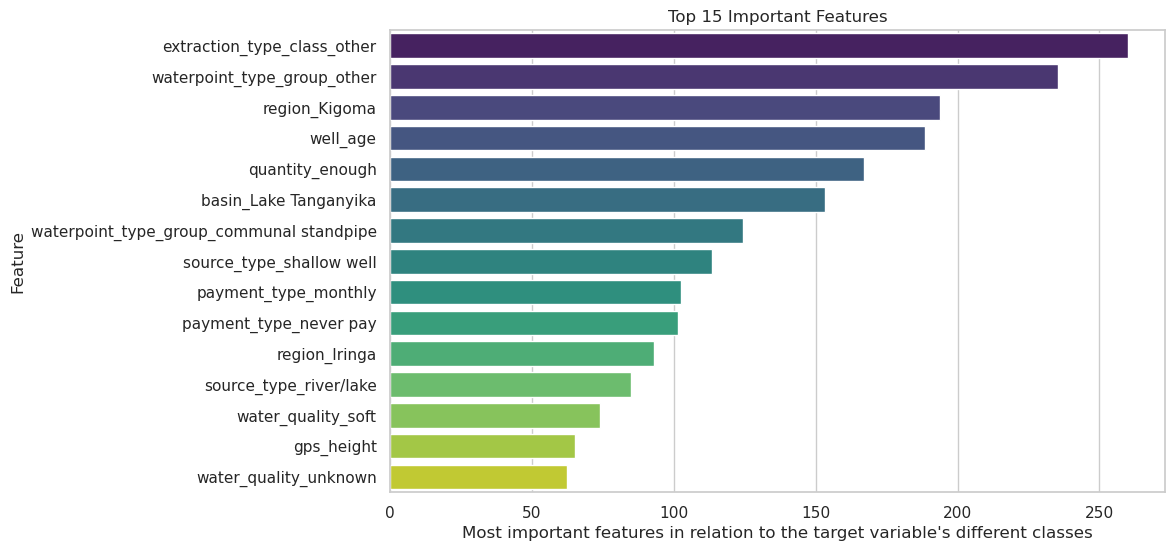

In [57]:
from sklearn.feature_selection import SelectKBest, f_classif
feature_names = X_train_final.columns.tolist()
scores, pvalues = f_classif(X_train_final, y_train_bal)

feature_scores_df = pd.DataFrame({
    'Feature': feature_names,
    'Score': scores,
    'P-Value': pvalues
})

# Sort by Score in descending order and select top 15 features
top_features = feature_scores_df.sort_values(by='Score', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=top_features, palette='viridis')
plt.xlabel("Most important features in relation to the target variable's different classes")
plt.ylabel('Feature')
plt.title('Top 15 Important Features')

# Save plot to images folder
plt.savefig("./images/top-15-important-features.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

Per the top-15-important-features plot; it is evident that `water_point_type_group`, `extraction_type_class`, `well_age`, `quantity`, `payment_type`, `region`, `source_type`, `basin`, `water_quality`, and `gps_height` features are significant predictor features for a water well's functional status. Thus, the preprocessed train set is clean, appropriately balanced. and adequately inclusive of the most important features, for predicting the target variable.

## 5 Model Evaluation
The final test dataset is loaded, and preprocessed it to match the training features. 

In [58]:
# Load test dataset
test_features = pd.read_csv('./data/testdata.csv')

# Display first five rows of the test set
test_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [59]:
# Preprocess the test set features using the same steps undertaken in preparing train_df

# 1. Drop irrelevant columns
test_features = test_features.drop(columns = ['funder', 'installer', 'latitude', 'longitude', 'scheme_name', 'wpt_name', 'num_private', 'subvillage', 'region_code', 'district_code', 'lga', 'ward', 'public_meeting', 'recorded_by'])

# 2. Engineer the `well_age` feature
test_features['date_recorded'] = pd.to_datetime(test_features['date_recorded']).dt.year
test_features['well_age'] = test_features['date_recorded'] - test_features['construction_year']

# 3. Drop rows where `well_age` is negative
test_features = test_features[test_features['well_age'] >= 0]

# 4. One-hot encode categorical features
test_cat_features = ohe.transform(test_features[cat_cols])
test_cat_feature_names = ohe.get_feature_names_out(cat_cols)
test_cat_df = pd.DataFrame(test_cat_features, columns=test_cat_feature_names, index=test_features.index)

# 5. Concatenate the one-hot encoded features with the rest of the test DataFrame
test_df_encoded = pd.concat([
    test_features.drop(columns=cat_cols),
    test_cat_df
], axis=1)

# 6. Scale the numerical features
test_df_encoded[num_cols_1] = scaler.transform(test_df_encoded[num_cols_1])

# 7. Ensure the test set has the same columns as the training set used for modeling
X_train_columns = X_train_final.columns.tolist()
test_df_encoded = test_df_encoded.reindex(columns=X_train_columns, fill_value=0)

# Display the preprocessed test set
test_df_encoded.head()

,gps_height,population,well_age,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,...,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_group_communal standpipe,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,0.917385,0.133750,0.022727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.723559,0.125000,0.295455,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.722651,0.208333,0.068182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.132547,0.104167,0.590909,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.583296,0.025000,0.295455,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


- Predict the `status_group` of entries in the testdata.csv dataset using the **Tuned Gradient Boosting Classifier** and format the results for submission as specified in SubmissionFormat.csv.

In [60]:
# Predict the status_group for the test set
test_predictions = gs_gb.predict(test_df_encoded)

# Create a submission DataFrame
submission_df = pd.DataFrame({
    'id': test_features['id'],
    'status_group': le.inverse_transform(test_predictions)
})

submission_df.head()

,id,status_group
0,50785,functional
1,51630,functional needs repair
2,17168,functional needs repair
3,45559,non functional
4,49871,functional


In [61]:
# Check shape
submission_df.shape

(14847, 2)

In [62]:
# Save the submission DataFrame to a CSV file
submission_df.to_csv('./data/final-submission.csv', index=False)

## 6 Conclusion, Recommendations, and Next Steps

### 6.1 Conclusion

The analysis of the Tanzanian water well dataset demonstrates that supervised machine learning models can effectively predict the functional status of water wells using historical and engineered features. Through comprehensive data cleaning, feature engineering (notably the creation of the `well_age` variable), and careful handling of class imbalance, we ensured the dataset was robust for modeling.

Among the models evaluated, the hyperparameter-tuned Gradient Boosting Classifier consistently outperformed both Logistic Regression and Decision Tree models across all key metrics. The tuned Gradient Boosting model achieved the highest F1-score (0.74 on the train set and 0.72 on the test set), accuracy (0.71 train, 0.69 test), and ROC-AUC (0.89 train, 0.86 test), indicating strong predictive power and generalization to unseen data. Both untuned and tuned Logistic Regression models performed reasonably well, with F1-scores around 0.71 and accuracy near 73%, but were limited

The ROC-AUC metric, which measures the model's ability to distinguish between the three well status classes, further confirmed the superiority of the tuned Gradient Boosting model. Its high ROC-AUC values reflect a strong ability to correctly rank wells by their likelihood of being functional, non-functional, or in need of repair.

In summary, the project confirms that with appropriate preprocessing, feature engineering, and model selection, machine learning can provide actionable insights for water well maintenance and resource allocation. The tuned Gradient Boosting Classifier is recommended for deployment due to its superior accuracy, balanced performance across all classes, and robustness against overfitting. The model was validated by calling it to predict the `status_group` values for 14,847 entries from a previously unseen dataset (**testdata.csv**). 